In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
#from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
import re

In [16]:
#df = pd.read_csv("/mnt/research/CMSE495-SS24-ICER/slurm_usage/DID_FINAL_SLURM_OCT_2023.csv",delimiter="|",nrows=1000000)
df = pd.read_csv("slurm_sample_data.csv")

In [17]:
def custom_to_minutes(time_str):
    if pd.isna(time_str):
        return None

    if '-' in time_str:
        days, time = time_str.split('-')
        hours, minutes, seconds = map(int, time.split(':'))
        total_minutes = int(days) * 24 * 60 + hours * 60 + minutes
    else:
        total_minutes = pd.to_timedelta(time_str).seconds // 60
def convert_to_minutes(td_str):
    td = pd.Timedelta(td_str)
    return td.total_seconds() / 60
#df['Timelimit'] = df['Timelimit'].apply(custom_to_minutes)

df['Timelimit_'] = df['Timelimit'].apply(convert_to_minutes)

df['time_column']=pd.to_timedelta(df['Elapsed'])
df['total_minutes']=df['time_column'].dt.total_seconds() / 60

In [18]:
na_count = df['Timelimit'].isna().sum()
print(na_count)

na_count = df['total_minutes'].isna().sum()
print(na_count)

0
0


In [19]:
df

,Unnamed: 0,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,...,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,Timelimit_,time_column,total_minutes
0,75766,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:11:08,0 days 00:02:38,COMPLETED,account_017,...,1,1,lac-351,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,348.380,19.0,0 days 00:02:38,2.633333
1,75880,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:30,2023-10-01T10:09:18,0 days 00:00:48,FAILED,account_017,...,1,1,lac-367,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,8.156,19.0,0 days 00:00:48,0.800000
2,77026,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:10:33,0 days 00:02:02,FAILED,account_017,...,1,1,lac-295,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,344.968,19.0,0 days 00:02:02,2.033333
3,77281,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:11:31,0 days 00:03:00,COMPLETED,account_017,...,1,1,lac-299,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,489.700,19.0,0 days 00:03:00,3.000000
4,76963,91806820,user_316,group_009,2023-10-01 10:08:04,2023-10-01 10:08:31,2023-10-01T10:09:36,0 days 00:01:05,FAILED,account_017,...,1,1,lac-294,"billing=1556,cpu=1,mem=10G,node=1","billing=1556,cpu=1,mem=10G,node=1",10000.0,270.400,19.0,0 days 00:01:05,1.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14266,29569,91740004,user_128,group_062,2023-10-01 00:37:59,2023-10-01 00:39:32,2023-10-01T00:46:35,0 days 00:07:03,COMPLETED,account_030,...,1,1,amr-162,"billing=1245,cpu=4,mem=8G,node=1","billing=1245,cpu=4,mem=8G,node=1",8000.0,531.208,1440.0,0 days 00:07:03,7.050000
14267,29572,91740008,user_128,group_062,2023-10-01 00:37:59,2023-10-01 00:39:38,2023-10-01T00:46:42,0 days 00:07:04,COMPLETED,account_030,...,1,1,amr-162,"billing=1245,cpu=4,mem=8G,node=1","billing=1245,cpu=4,mem=8G,node=1",8000.0,528.908,1440.0,0 days 00:07:04,7.066667
14268,29575,91740012,user_128,group_062,2023-10-01 00:38:00,2023-10-01 00:39:43,2023-10-01T00:45:59,0 days 00:06:16,COMPLETED,account_030,...,1,1,amr-162,"billing=1245,cpu=4,mem=8G,node=1","billing=1245,cpu=4,mem=8G,node=1",8000.0,490.392,1440.0,0 days 00:06:16,6.266667
14269,29530,91739952,user_128,group_062,2023-10-01 00:37:49,2023-10-01 00:38:49,2023-10-01T00:50:17,0 days 00:11:28,COMPLETED,account_030,...,1,1,amr-162,"billing=1245,cpu=4,mem=8G,node=1","billing=1245,cpu=4,mem=8G,node=1",8000.0,747.872,1440.0,0 days 00:11:28,11.466667


In [33]:
#PCA
#features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_']
features3=['CPUTimeRAW','ReqCPUS','AllocCPUS','ReqNodes','NNodes','total_minutes','Timelimit_','ReqMem_MB']


df_pca=df[features3]
scaler = StandardScaler()
df_pca=scaler.fit_transform(df_pca)
pca = PCA(2)
df_pca1 = pca.fit_transform(df_pca)

df_pca1

/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/software/Python/3.6.4-foss-2018a/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-0.41193641,  0.54774505],
       [-0.41236748,  0.54917217],
       [-0.41207749,  0.54821211],
       ...,
       [-0.06420156,  0.24834979],
       [-0.06269848,  0.24407269],
       [-0.06326214,  0.2456766 ]])

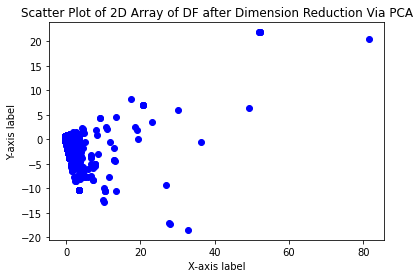

In [34]:
#PCA Graph
df_pca_scatter=df_pca1.T
plt.scatter(df_pca_scatter[0], df_pca_scatter[1], marker='o', color='blue')

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter Plot of 2D Array of DF after Dimension Reduction Via PCA')

# Show the plot
plt.show()

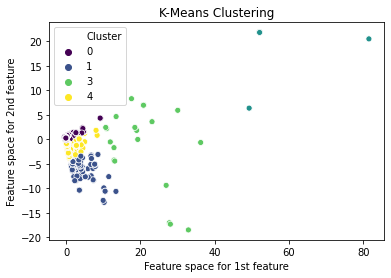

In [35]:
#K-Means
k=5
df_pca1 = pd.DataFrame(df_pca1, columns=['Feature space for 1st feature', 'Feature space for 2nd feature'])
kmeans = KMeans(n_clusters=k,algorithm='auto',init='k-means++',max_iter=300)
kmeans.fit_predict(df_pca1)
labels = kmeans.labels_
df_pca1['Cluster'] = labels
sns.scatterplot(x=df_pca1['Feature space for 1st feature'], y=df_pca1['Feature space for 2nd feature'], hue='Cluster', data=df_pca1, palette='viridis')
plt.title('K-Means Clustering')

plt.show()

In [36]:
print("Explained Variance for Each Principal Component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i + 1}: {var:.2%}")
    
    
loadings_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=df[features3].columns)

# Display the loadings for each feature in the final two principal components
print("Loadings for PC1 and PC2:")
print(loadings_df[['PC1', 'PC2']])

Explained Variance for Each Principal Component:
PC1: 44.36%
PC2: 24.12%
Loadings for PC1 and PC2:
                    PC1       PC2
CPUTimeRAW     0.339537 -0.277614
ReqCPUS        0.503054  0.202360
AllocCPUS      0.508695  0.203628
ReqNodes       0.263119  0.039929
NNodes         0.484003  0.230622
total_minutes  0.186350 -0.655392
Timelimit_     0.186182 -0.596822


In [25]:
cluster_counts = Counter(labels)
percentages = {cluster: count / len(df) * 100 for cluster, count in cluster_counts.items()}
table_data = pd.DataFrame(list(percentages.items()), columns=['Cluster Label', 'Percentage (%)'])
print(table_data)

   Cluster Label  Percentage (%)
0              0       86.174760
1              3       11.758111
2              4        1.884941
3              1        0.126130
4              2        0.056058
